In [1]:
#This file contains code to extract all the emotes from the output csv file of the Llama , and calculate
#details such as the number of times it was seen as toxic and non-toxic.
import pickle
import numpy as np
import pandas as pd


#Function to compute global and channel emotes and write them to csv files
# def compute_and_write_emotestocsv():
#     global_emotes_df = emotes_df[["GLOBAL_TWITCH", "GLOBAL_FFZ", "GLOBAL_7TV"]]
#     global_emotes_df = pd.merge(global_emotes_df, bttv_emotes_df["GLOBAL_BTTV"], left_index=True, right_index=True)
#     global_emotes_df.fillna("", inplace = True)

#     #Get list of all channel emotes
#     channel_emotes_df = emotes_df.loc[:, ~emotes_df.columns.isin(["TEXT", "GLOBAL_TWITCH", "GLOBAL_FFZ", "GLOBAL_7TV"])]
#     channel_bttv_emotes_df = bttv_emotes_df.loc[:, ~bttv_emotes_df.columns.isin(["GLOBAL_BTTV"])]
#     channel_ffz_emotes_df = ffz_emotes_df

#     channel_total_emotes_df = pd.merge(channel_emotes_df, channel_bttv_emotes_df, on = None, how = "outer")
#     channel_total_emotes_df = pd.merge(channel_total_emotes_df, channel_ffz_emotes_df, on = None, how = "outer")
#     channel_total_emotes_df.fillna("", inplace = True)

#     #Write all global emotes (with extensions) and channel emotes to csv files
#     global_emotes_df.to_csv("global_emotes.csv", index = False)
#     channel_total_emotes_df.to_csv("channel_emotes.csv", index = False)


#Function that reads global emote and channel emote csv files and returns them
def read_emotes_from_csv():
    global_emotes_df = pd.read_csv("global_emotes.csv")
    #Get list of all global emotes (including extensions)
    global_emotes1 = [x for x in emotes_df[["GLOBAL_TWITCH", "GLOBAL_FFZ", "GLOBAL_7TV"]].values.flatten() if x != '']
    global_emotes2 = [x for x in bttv_emotes_df["GLOBAL_BTTV"].values.flatten() if x != '']
    global_emotes_list = global_emotes1 + global_emotes2

    channel_emotes_df = pd.read_csv("channel_emotes.csv")
    #Renaming columns that start with numbers to avoid potential conflict with Pandas
    channel_emotes_df.columns = ['Col_' + str(col) if col[0].isdigit() else col for col in channel_emotes_df.columns]
    channel_emotes_df.fillna("", inplace = True)
    channel_emotes_df = channel_emotes_df.reset_index(drop = True)

    return [global_emotes_list, channel_emotes_df]



def wordIsChannelOrGlobalEmote(word, channel_emotes_df, global_emotes_list):
    """
    Returns whether the word is a global emote, channel emote or not an emote

    Param: word - current word as a string
    Return: global if it is global emote, channel name if it belongs to channel, No if it is not an emote
    """

    column_with_word = []

    channel = "HasanAbi" #only considering Hasan channel for ease of time
    #for channel in channel_emotes_df.columns:
    if (channel_emotes_df[channel] == word).any() and word != "":
        column_with_word.append(channel)

    if word in global_emotes_list:
        return "global" #return that its global
    elif len(column_with_word) > 0:
        return column_with_word[0].removeprefix("Col_") #return channel name
    else:
        return "no" #not an emote



# Load registered emotes into pandas dataframes
#emotes_df has the global twitch, global ffz, global 7tv, and then the base emotes for all streamer channels
with open('emote_dict', 'rb') as f:
    emotes_df = pickle.load(f) #emotes is a Pandas Dataframe (255 rows x 2383 columns)
    emotes_df.replace(['NaN', 'nan'], np.nan, inplace = True)
    emotes_df.fillna("", inplace = True)


#bttv_emotes has global bttv emotes in one column and then bttv emotes from streamers in other columns
with open('bttv_dict', 'rb') as f:
    bttv_emotes_df = pickle.load(f) #495 rows x 2023 columns
    bttv_emotes_df.replace(['NaN', 'nan'], np.nan, inplace = True)
    bttv_emotes_df.fillna("", inplace = True)

#ffz_emotes has ffz emotes from streamers
with open('ffz_dict', 'rb') as f:
    ffz_emotes_df = pickle.load(f).T #76 rows x 321 columns
    ffz_emotes_df.replace(['NaN', 'nan'], np.nan, inplace = True)
    ffz_emotes_df.fillna("", inplace = True)

#Only need to compute_and_writetocsv() once to write all the emotes
#compute_and_write_emotestocsv()
global_emotes_list, channel_emotes_df = read_emotes_from_csv()

"""Read toxicity csv file output generated by Llama"""
#only need comment_text and toxic column (RoBERTa)
toxicity_df = pd.read_csv("toxic_with_labels.csv", usecols = ["comment_text", "toxic"])
toxicity_df = toxicity_df.dropna() #remove rows with null values

#This will contain the emote as a key and then the values will be the # of times emote was toxic, number of times not toxic and then whether it is global or channel emote
emote_toxicity_dict = {}


counter = 0
#Go through each row in dataframe
for index, row in toxicity_df.iterrows():
    wordsList = row["comment_text"].split(" ") #Get list of words from each comment

    for word in wordsList: #go through each word in comment
        wordIsEmote = wordIsChannelOrGlobalEmote(word, channel_emotes_df, global_emotes_list)

        if wordIsEmote == "no":
            continue #not an emote so ignore this word

        elif wordIsEmote == "global": #global emote
            if word in emote_toxicity_dict: #if this emote was already added
                if row["toxic"] == "no": #not toxic emote
                    emote_toxicity_dict[word][1] += 1 #increment number of times not toxic
                else: #toxic emote
                    emote_toxicity_dict[word][0] += 1 #increment number of times it was toxic

            else: #if this emote was not in toxic dictionary before
                if row["toxic"] == "no": #not toxic emote
                    emote_toxicity_dict[word] = [0,1, True, False]
                else: #toxic emote
                    emote_toxicity_dict[word] = [1,0,True, False]

        else: #channel emote
            if word in emote_toxicity_dict: #if this emote was already added
                if row["toxic"] == "no": #not toxic emote
                    emote_toxicity_dict[word][1] += 1 #increment number of times not toxic
                else: #toxic emote
                    emote_toxicity_dict[word][0] += 1 #increment number of times it was toxic

            else: #if this emote was not in toxic dictionary before
                if row["toxic"] == "no": #not toxic emote
                    emote_toxicity_dict[word] = [0,1, False, wordIsEmote]
                else: #toxic emote
                    emote_toxicity_dict[word] = [1,0,False, wordIsEmote]
    counter += 1

    if counter % 1000 == 0:
        print(str(counter) + " rows have been processed")



# Convert dictionary to dataframe and write results to final csv file
df = pd.DataFrame.from_dict(emote_toxicity_dict, orient='index', columns = ['Number of times emote was toxic', 'Number of times emote was NOT toxic', "Global emote", "Channel emote"])
df = df.rename_axis('Emote').reset_index()

# Example output
print(df.head(10))

#df["Number of times emote was used"] = df["Number of times emote was NOT toxic"] + df["Number of times emote was toxic"]
df["Toxicity Ratio"] = df["Number of times emote was toxic"] / (df["Number of times emote was NOT toxic"] + df["Number of times emote was toxic"]) #last column to provide us with toxicity ratio

df.to_csv("ToxicityRatio_From_Output_RoBERTa.csv")


<ipython-input-1-b919315fd911>:36: DtypeWarning: Columns (0,1,3,5,6,7,8,9,10,11,12,13,14,15,17,18,19,20,21,22,23,25,27,29,30,31,32,33,34,35,36,37,38,40,41,42,44,46,47,48,50,51,52,54,55,56,57,58,59,60,61,62,63,64,65,67,68,69,70,71,72,73,74,75,76,77,78,79,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,102,104,105,107,108,109,110,111,112,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,213,214,215,216,218,219,220,221,222,223,224,225,226,227,229,232,233,234,235,236,239,241,242,243,244,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,263,264,265,266,267,268,270,271,273,277,278,279,280,281,282,283,285,286,287,288,290,291,292,293,294,295,297,2

1000 rows have been processed
2000 rows have been processed
3000 rows have been processed
4000 rows have been processed
5000 rows have been processed
6000 rows have been processed
7000 rows have been processed
8000 rows have been processed
9000 rows have been processed
10000 rows have been processed
11000 rows have been processed
         Emote  Number of times emote was toxic  \
0      Jupijej                               12   
1       LETSGO                               54   
2  HYPERPOGGER                                0   
3  bleedPurple                                0   
4    KappaRoss                                0   
5         hasL                                6   
6      hasRaid                                5   
7         VIBE                                0   
8       Okayge                                0   
9      NODDERS                                6   

   Number of times emote was NOT toxic  Global emote Channel emote  
0                                  15

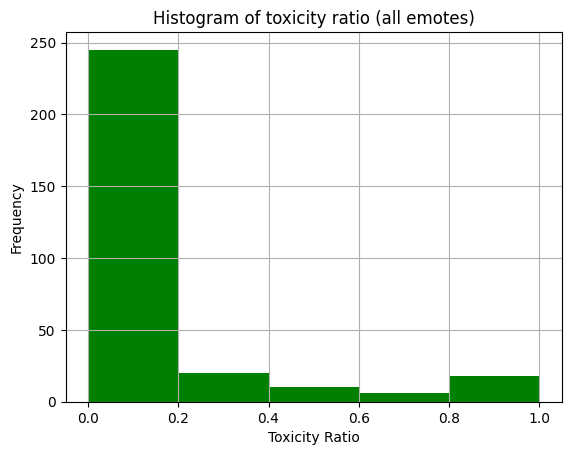

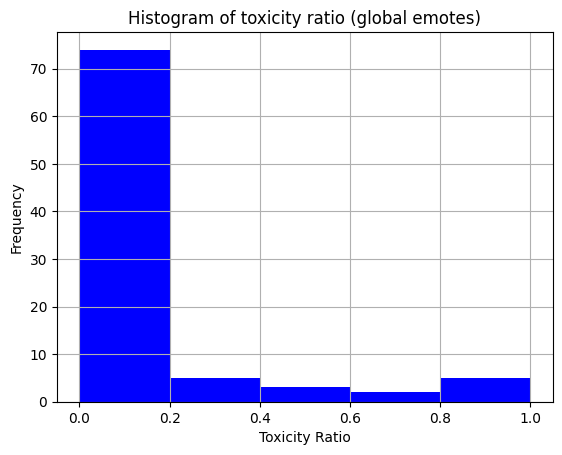

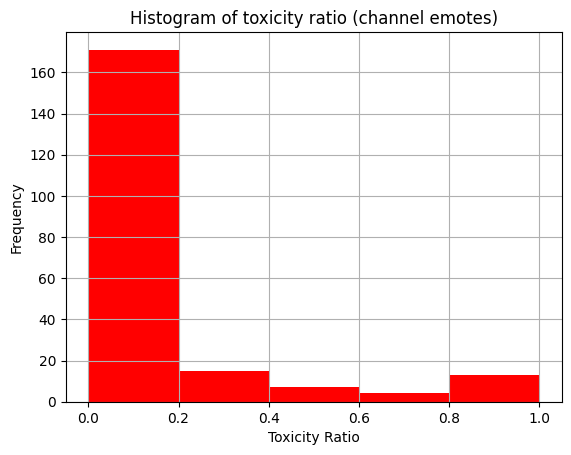

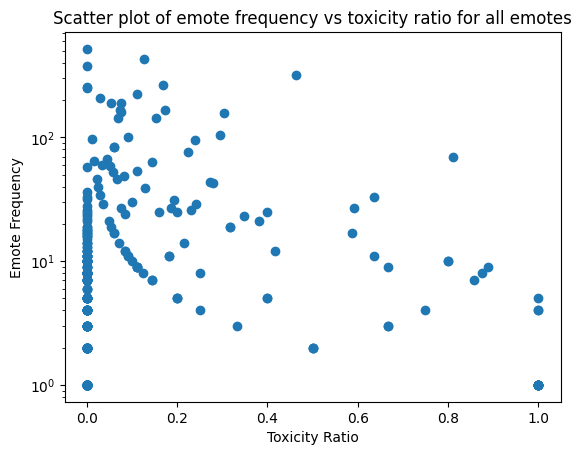

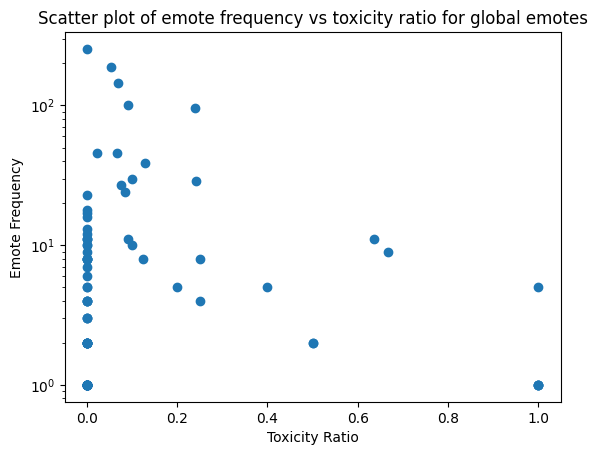

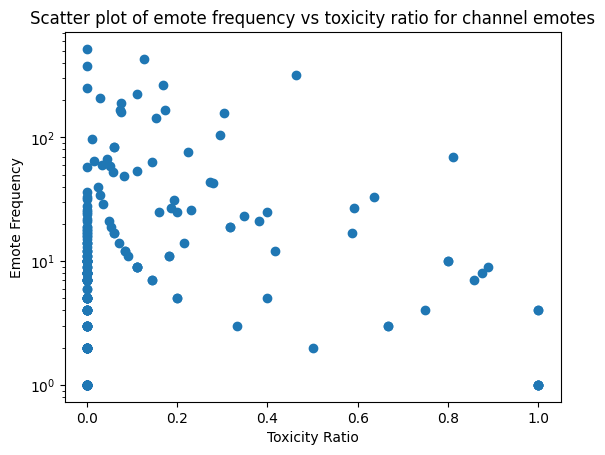

In [3]:
"""
This file has code to plot the histogram for the toxicity ratio
In addition, we make a scatter plot of number of times emote was used vs toxicity ratio.

"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


#Read csv file
df = pd.read_csv("ToxicityRatio_From_Output_RoBERTa.csv")

#Replacing the infinities with a large finite value for plotting the histogram
df['Toxicity Ratio'].replace(np.inf, np.nan, inplace=True)
df['Toxicity Ratio'].replace(-np.inf, np.nan, inplace=True)
df = df.dropna().reset_index(drop = True)


#Retrieving toxicity ratio for all emotes, global emotes and channel emotes
df_toxicityratio = df["Toxicity Ratio"]
df_toxicityratioglobalemotes = df[df["Global emote"] == True]["Toxicity Ratio"].reset_index(drop = True)
df_toxicityratiochannelemotes = df[df["Channel emote"] != "False"]["Toxicity Ratio"].reset_index(drop = True)


#Retrieving emote frequency for all emotes, only global emotes, and channel emotes
df_emotefrequency = df["Number of times emote was toxic"] + df["Number of times emote was NOT toxic"]
df["Emote frequency"] = df_emotefrequency
df_emotefrequencyglobalemotes = df[df["Global emote"] == True]["Emote frequency"].reset_index(drop = True)
df_emotefrequencychannelemotes = df[df["Channel emote"] !="False"]["Emote frequency"].reset_index(drop = True)



###PLOT 1a : HISTOGRAM FOR TOXICITY RAIO OF EMOTES####################

# Plot the histogram for toxicity ratio of all emotes
plt.hist(df_toxicityratio, bins = int((df_toxicityratio.max() - df_toxicityratio.min()) / 0.2), color = "green")
plt.title('Histogram of toxicity ratio (all emotes)')
plt.xlabel('Toxicity Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

###PLOT 1b: HISTOGRAM FOR TOXICITY RATIO OF only global emotes#############
plt.hist(df_toxicityratioglobalemotes, bins = int((df_toxicityratioglobalemotes.max() - df_toxicityratioglobalemotes.min()) / 0.2), color = "blue")
plt.title('Histogram of toxicity ratio (global emotes)')
plt.xlabel('Toxicity Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


###PLOT 1c: HISTOGRAM FOR TOXICITY RATIO OF only channel emotes#############
plt.hist(df_toxicityratiochannelemotes, bins = int((df_toxicityratiochannelemotes.max() - df_toxicityratiochannelemotes.min()) / 0.2), color = "red")
plt.title('Histogram of toxicity ratio (channel emotes)')
plt.xlabel('Toxicity Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



########## PLOT 2a: SCATTER PLOT OF y (Emote frequency) x (toxicity ratio) #############
plt.scatter(df_toxicityratio, df_emotefrequency)
plt.yscale('log')
plt.title('Scatter plot of emote frequency vs toxicity ratio for all emotes')
plt.xlabel('Toxicity Ratio')
plt.ylabel('Emote Frequency')
plt.show()

########## PLOT 2b: SCATTER PLOT OF y (Emote frequency) x (toxicity ratio) for only global emotes #############
plt.scatter(df_toxicityratioglobalemotes, df_emotefrequencyglobalemotes)
plt.yscale('log')
plt.title('Scatter plot of emote frequency vs toxicity ratio for global emotes')
plt.xlabel('Toxicity Ratio')
plt.ylabel('Emote Frequency')
plt.show()

########## PLOT 2c: SCATTER PLOT OF y (Emote frequency) x (toxicity ratio) for only channel emotes  #############
plt.scatter(df_toxicityratiochannelemotes, df_emotefrequencychannelemotes)
plt.yscale('log')
plt.title('Scatter plot of emote frequency vs toxicity ratio for channel emotes')
plt.xlabel('Toxicity Ratio')
plt.ylabel('Emote Frequency')
plt.show()


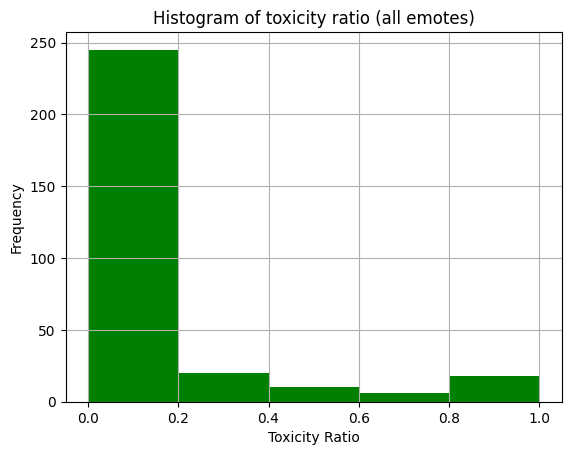

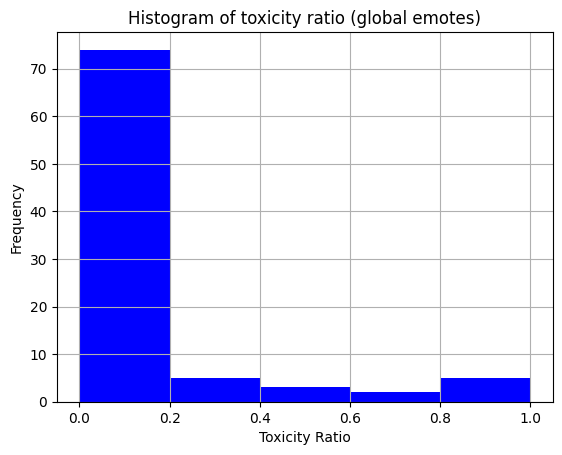

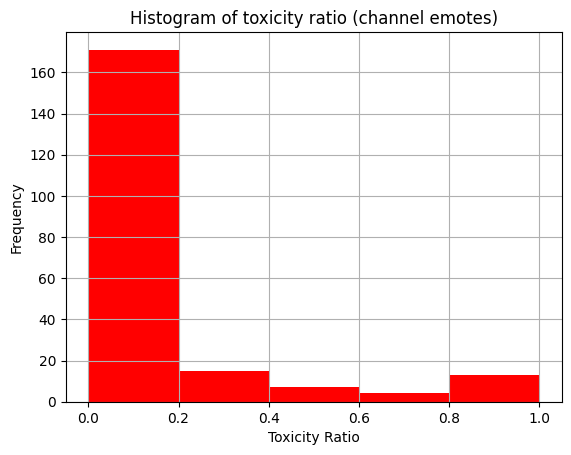

JS distance between distributions for global and channel emotes is: 0.030435377689244283


In [6]:
"""
This file has code to plot the histogram for the toxicity ratio
In addition, we make a scatter plot of number of times emote was used vs toxicity ratio.

"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import jensenshannon


#Read csv file
df = pd.read_csv("ToxicityRatio_From_Output_RoBERTa.csv")

#Replacing the infinities with a large finite value for plotting the histogram
df['Toxicity Ratio'].replace(np.inf, np.nan, inplace=True)
df['Toxicity Ratio'].replace(-np.inf, np.nan, inplace=True)
df = df.dropna().reset_index(drop = True)


#Retrieving toxicity ratio for all emotes, global emotes and channel emotes
df_toxicityratio = df["Toxicity Ratio"]
df_toxicityratioglobalemotes = df[df["Global emote"] == True]["Toxicity Ratio"].reset_index(drop = True)
df_toxicityratiochannelemotes = df[df["Channel emote"] != "False"]["Toxicity Ratio"].reset_index(drop = True)


#Retrieving emote frequency for all emotes, only global emotes, and channel emotes
df_emotefrequency = df["Number of times emote was toxic"] + df["Number of times emote was NOT toxic"]
df["Emote frequency"] = df_emotefrequency
df_emotefrequencyglobalemotes = df[df["Global emote"] == True]["Emote frequency"].reset_index(drop = True)
df_emotefrequencychannelemotes = df[df["Channel emote"] !="False"]["Emote frequency"].reset_index(drop = True)



### HISTOGRAM FOR TOXICITY RAIO OF EMOTES#############

# Plot the histogram for toxicity ratio of all emotes
height1,bin1,param1= plt.hist(df_toxicityratio, bins = int((df_toxicityratio.max() - df_toxicityratio.min()) / 0.2), color = "green")
plt.title('Histogram of toxicity ratio (all emotes)')
plt.xlabel('Toxicity Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

total_height1=height1/sum(height1)

### HISTOGRAM FOR TOXICITY RATIO OF only global emotes######
height2,bin2,param2 = plt.hist(df_toxicityratioglobalemotes, bins = int((df_toxicityratioglobalemotes.max() - df_toxicityratioglobalemotes.min()) / 0.2), color = "blue")
plt.title('Histogram of toxicity ratio (global emotes)')
plt.xlabel('Toxicity Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

total_height2=height2/sum(height2)

### HISTOGRAM FOR TOXICITY RATIO OF only channel emotes####
height3,bin3,param3 = plt.hist(df_toxicityratiochannelemotes, bins = int((df_toxicityratiochannelemotes.max() - df_toxicityratiochannelemotes.min()) / 0.2), color = "red")
plt.title('Histogram of toxicity ratio (channel emotes)')
plt.xlabel('Toxicity Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

total_height3=height3/sum(height3)

jsDist=jensenshannon(total_height2,total_height3,base=2)

print("JS distance between distributions for global and channel emotes is:",jsDist)

